In [95]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
import scipy as sp
# import scipy.sparse
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
# import graphlab as gl
import sklearn.metrics
import ast
%matplotlib inline

from matrix_factorization_recommender import MatrixFactorizationRecommender
from simple_averaging_recommender import SimpleAveragingRecommender

from scipy.sparse import csr_matrix

businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')

phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)

In [96]:
# phoenix_reviews = phoenix_reviews
phoenix_reviews = phoenix_reviews.iloc[0:15000]
phoenix_restaurants = phoenix_restaurants[phoenix_restaurants['business_id'].isin(phoenix_reviews['business_id'])]
phoenix_users = phoenix_users[phoenix_users['user_id'].isin(phoenix_reviews['user_id'])]

In [97]:
from baseline_calculator import DecoupledRegularizedBaselineCalculator

In [98]:
reviews_train, reviews_test = train_test_split_reviews(phoenix_reviews)

In [99]:
bc = DecoupledRegularizedBaselineCalculator()
bc.fit(reviews_train, busi_reg_strength=2.5, user_reg_strength=5)
bc.transform(reviews_train, key='baseline_stars')
bc.transform(reviews_test, key='baseline_stars')
bc.baseline_rmse(reviews_test)

1.188619751303192

In [111]:
### phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
# interesting columns
columns_of_interest = ['business_id',
                     'attributes',
                     'categories',
                     'city',
#                      'hours', # looks complicated
                     'latitude',
                     'longitude',
                     'neighborhoods',
                     'open',
                     'review_count',
                     'stars']
phoenix_restaurants = phoenix_restaurants[columns_of_interest]

def flatten(dct, separator='_'):
    """A fast way to flatten a dictionary,"""
    res = {}
    queue = [('', dct)]

    while queue:
        prefix, d = queue.pop()
        for k, v in d.items():
            key = prefix + k
            if not isinstance(v, dict):
                res[key] = [v]
            else:
                queue.append((key + separator, v))
    return res

def parse_data(row):
    attribs = flatten(ast.literal_eval(row.attributes))
    categories = ast.literal_eval(row.categories)
    neighborhoods = ast.literal_eval(row.neighborhoods)
    attributes = pd.DataFrame.from_dict(attribs, orient='columns')
    categories = pd.DataFrame.from_dict(dict([[c, [1]] for c in categories]))
    neighborhoods = pd.DataFrame.from_dict(dict([[n, [1]] for n in neighborhoods]))
    city = row.city
    row = row.drop(['attributes', 'categories', 'neighborhoods', 'city'])
    city = pd.DataFrame([1], index=[city])
    if (neighborhoods.shape[0] > 0) & (attributes.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], neighborhoods.iloc[0], pd.get_dummies(attributes).iloc[0], city.iloc[0]), axis=0)
    elif (neighborhoods.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], neighborhoods.iloc[0], city.iloc[0]), axis=0)
    elif (attributes.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], pd.get_dummies(attributes).iloc[0], city.iloc[0]), axis=0)
    else:
        result = pd.concat((row, categories.iloc[0], city.iloc[0]), axis=0)
    return result.astype(np.float32).to_sparse()

phoenix_bus_update = phoenix_restaurants.apply(parse_data,axis=1,)
# phoenix_update = pd.concat((phoenix_update, pd.get_dummies(phoenix_update['city'])), axis=1)
# phoenix_update = phoenix_update.drop('city', axis=1)
phoenix_bus_update = phoenix_bus_update.fillna(0)
phoenix_bus_update.head(2)

,0,Accepts Credit Cards,Active Life,Adult Entertainment,Ages Allowed_21plus,Alcohol_beer_and_wine,Alcohol_full_bar,Alcohol_none,Ambience_casual,Ambience_classy,...,Wi-Fi_free,Wi-Fi_no,Wi-Fi_paid,Wine Bars,business_id,latitude,longitude,open,review_count,stars
2377,1,1,0,0,0,0,0,1,0,0,...,0,1,0,0,2377,33.479481,-112.073677,1,20,3.0
2378,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2378,33.468548,-112.075089,1,6,3.5


In [112]:
# phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
# interesting columns
columns_of_interest = ['user_id',
                    'average_stars',
                     'compliments',
                     'elite',
                     'fans',
                    'votes',
#                      'hours', # looks complicated
                     'review_count',
#                      'yelping_since'
                      ]
phoenix_users = phoenix_users[columns_of_interest]

def parse_data(row):
    compliments = pd.DataFrame.from_dict(flatten(ast.literal_eval(row.compliments)), orient='columns')
    votes = pd.DataFrame.from_dict(flatten(ast.literal_eval(row.votes)), orient='columns')
    elite = pd.DataFrame.from_dict(dict([['elite_{}'.format(e), [1]] for e in ast.literal_eval(row.elite)]))
    
    compliments.columns = ['compliment_' + c for c in compliments.columns]
    votes.columns = ['vote' + v for v in votes.columns]
    
    row = row.drop(['compliments', 'votes', 'elite'])
 
    if (elite.shape[0] > 0) & (votes.shape[0] > 0) & (compliments.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0], votes.iloc[0],  compliments.iloc[0]), axis=0)
    elif (elite.shape[0] > 0) & (votes.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0], votes.iloc[0]), axis=0)
    elif (elite.shape[0] > 0) & (compliments.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0], compliments.iloc[0]), axis=0)
    elif (votes.shape[0] > 0) & (compliments.shape[0] > 0):
        result = pd.concat((row, votes.iloc[0], compliments.iloc[0]), axis=0)
    elif (elite.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0]), axis=0)
    elif (votes.shape[0] > 0):
        result = pd.concat((row, votes.iloc[0]), axis=0)    
    elif (compliments.shape[0] > 0):
        result = pd.concat((row, compliments.iloc[0]), axis=0)
    else:
        result = row
    return result.astype(np.float32).to_sparse()

phoenix_users_update = phoenix_users.apply(parse_data,axis=1,)
phoenix_users_update = phoenix_users_update.fillna(0)
phoenix_users_update.head(2)

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,elite_2013,elite_2014,elite_2015,elite_2016,fans,review_count,user_id,votecool,votefunny,voteuseful
48,3.00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,48,0,0,0
284,3.33,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,6,284,2,2,20


In [113]:
# bus_u = list(reviews_train.business_id.unique())
# user_u = list(reviews_train.user_id.unique())

# data = []
# row = []
# col = []
# test = pd.DataFrame()
# for user_id, group in reviews_train.groupby('user_id'):
#     for review_id, review in group.iterrows():
#         my_metadata = group[group.index != review_id]
#         for r_id, rev in my_metadata.iterrows():
#             phoenix_users_update = phoenix_users_update.set_value(user_id, rev['business_id'], rev['stars'])

In [114]:
combined_reviews_train = pd.merge(pd.merge(reviews_train,
    phoenix_bus_update.fillna(0), on='business_id', suffixes=('','_business')),
    phoenix_users_update.fillna(0), on='user_id', suffixes=('','_user'))

In [115]:
combined_reviews_test = pd.merge(pd.merge(reviews_test,
    phoenix_bus_update.fillna(0), on='business_id', suffixes=('','_business')),
    phoenix_users_update.fillna(0), on='user_id', suffixes=('','_user'))

In [116]:
def strip_cols(df):
    return df.drop(['user_id',
             'business_id',  
             'average_stars', 
             'stars_business',
             'stars',
             'baseline_stars'], axis=1)

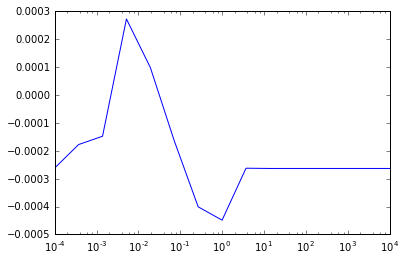

In [117]:
scores = []
for i in np.logspace(-4,4,15):
    las = sklearn.linear_model.Lasso(alpha=i)
    las.fit(strip_cols(combined_reviews_train), combined_reviews_train.baseline_stars)
    s = las.score(strip_cols(combined_reviews_test), combined_reviews_test.baseline_stars)
    scores.append(s)
plt.semilogx(np.logspace(-4,4,15), scores)

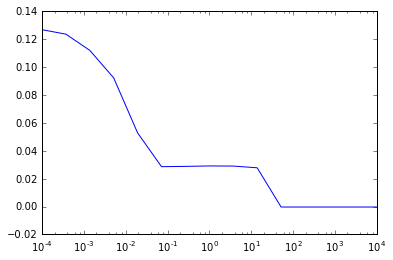

In [118]:
scores = []
for i in np.logspace(-4,4,15):
    las = sklearn.linear_model.Lasso(alpha=i)
    las.fit(strip_cols(combined_reviews_train), combined_reviews_train.stars)
    s = las.score(strip_cols(combined_reviews_test), combined_reviews_test.stars)
    scores.append(s)
plt.semilogx(np.logspace(-4,4,15), scores)

In [119]:
las = sklearn.linear_model.Lasso(alpha=10**-3)
las.fit(strip_cols(combined_reviews_train), combined_reviews_train.stars)
strip_cols(combined_reviews_test).columns[np.abs(las.coef_)>0]

Index([u'year', u'month', u'day', u'Alcohol_beer_and_wine', u'Alcohol_none',
       u'Ambience_casual', u'Ambience_divey', u'Ambience_hipster',
       u'Ambience_intimate', u'Ambience_romantic',
       ...
       u'elite_2011', u'elite_2012', u'elite_2014', u'elite_2015',
       u'elite_2016', u'fans', u'review_count_user', u'votecool', u'votefunny',
       u'voteuseful'],
      dtype='object', length=103)

In [120]:
las = sklearn.linear_model.Lasso(alpha=10**-2)
las.fit(strip_cols(combined_reviews_train), combined_reviews_train.baseline_stars)
strip_cols(combined_reviews_test).columns[np.abs(las.coef_)>0]

Index([u'year', u'month', u'day', u'review_count', u'compliment_cool',
       u'compliment_cute', u'compliment_funny', u'compliment_hot',
       u'compliment_list', u'compliment_more', u'compliment_note',
       u'compliment_photos', u'compliment_plain', u'compliment_profile',
       u'compliment_writer', u'fans', u'review_count_user', u'votecool',
       u'votefunny', u'voteuseful'],
      dtype='object')

In [121]:
las = sklearn.linear_model.Lasso(alpha=10**-4)
las.fit(strip_cols(combined_reviews_train), combined_reviews_train.stars)
x_pred = las.predict(strip_cols(combined_reviews_test))
np.sqrt(sklearn.metrics.mean_squared_error(combined_reviews_test.stars,
                                           bc.inverse_transform(reviews_test, x_pred)))

1.8059508778001112

In [122]:
combined_reviews_test.columns[np.abs(las.coef_)>0]

/Users/nickhoernle/anaconda2/lib/python2.7/site-packages/pandas/core/index.py:1160: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 189 but corresponding boolean dimension is 183
  result = getitem(key)


Index([             u'user_id',          u'business_id',
                       u'year',                u'stars',
                             0, u'Accepts Credit Cards',
                u'Active Life',  u'Adult Entertainment',
        u'Ages Allowed_21plus',     u'Alcohol_full_bar',
       ...
                 u'elite_2006',           u'elite_2007',
                 u'elite_2008',           u'elite_2009',
                 u'elite_2010',           u'elite_2011',
                 u'elite_2012',           u'elite_2013',
                 u'elite_2014',           u'elite_2015'],
      dtype='object', length=152)